Model: xgboost \\
Features: kenpom \\
Trainings sets:

In [57]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.cross_validation import PredefinedSplit, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.grid_search import GridSearchCV
import itertools
import pandas as pd
import numpy as np
import random

In [73]:
data = pd.DataFrame.from_csv("kenpom_team_ratings.csv")
spellings = pd.DataFrame.from_csv("march_madness_2016_data/TeamSpellings.csv")
seeds = pd.DataFrame.from_csv("march_madness_2016_data/TourneySeeds.csv")
teams = pd.DataFrame.from_csv("march_madness_2016_data/teams.csv")
tourney_data = pd.DataFrame.from_csv("march_madness_2016_data/TourneyCompactResults.csv")

# Add names from kenpoms website
names_to_add = {'mississippi valley st.':'1290',
                'arkansas pine bluff':'1115',
                'arkansas little rock':'1114',
                'louisiana lafayette':'1418',
                'cal st. bakersfield':'1167',
                'illinois chicago':'1227',
                'texas a&m corpus chris':'1394'}

for name_to_add in names_to_add:
    spellings.ix[name_to_add,:] = names_to_add[name_to_add]
    
a = data['Team'].copy()
a.sort_values(axis=0)
a.unique()
b = pd.Series()
for i, a_ in enumerate(a):
    new = a_.split(" ")
    if new[-1].isdigit():
        new = " ".join(new[:-1])
        b.set_value(i, new)
    else:
        b.set_value(i, a_)
b = sorted(b.unique())

years = range(2002,2016)
teams_from_kenpom = [[] for _ in years]
teams_from_kaggle = [[] for _ in years]

for i, year in enumerate(years):
    year_seeds = list(seeds.loc[str(year)]['Team'])
    seeds_used = []
    for b_ in b:
        try:
            team_id = spellings.loc[b_.lower()]
            if int(team_id) in year_seeds and int(team_id) not in seeds_used:
                teams_from_kenpom[i].append([b_, int(team_id)])
                seeds_used.append(int(team_id))
        except KeyError:
            pass
        
for i, year in enumerate(years):
    year_seeds = list(seeds.loc[str(year)]['Team'])
    for seed in year_seeds:
        index = seed - 1101
        name = teams.iloc[index]
        teams_from_kaggle[i].append([name[0], int(seed)])
        
for i in xrange(len(years)):
    teams_from_kenpom[i].sort(key=lambda x: x[1])
    teams_from_kaggle[i].sort(key=lambda x: x[1])
    
# Compare kaggle names to kenpom names to ensure that all teams are correctly saved
"""i = 7
print len(teams_from_kenpom[i])
print len(teams_from_kaggle[i])
zip(teams_from_kenpom[i], teams_from_kaggle[i])"""

'i = 7\nprint len(teams_from_kenpom[i])\nprint len(teams_from_kaggle[i])\nzip(teams_from_kenpom[i], teams_from_kaggle[i])'

In [867]:
X = pd.DataFrame()
Y = []
cv_indices = []

In [868]:
features_to_include = ['AdjEM',
                       'AdjO',
                       'AdjD',
                       'AdjT',
                       'Wins',
                       'Losses']
features_to_include_both_teams = []
for feature in features_to_include:
    features_to_include_both_teams.append(feature + '_x')
    features_to_include_both_teams.append(feature + '_y')

In [869]:
# Identify data to keep for cross-validation
cv_years = [2014]

index = 0

for i, year in enumerate(years):
    year_teams = pd.DataFrame(teams_from_kenpom[i])
    year_teams.columns = ['Team', 'Team_ID']
    year_data = data[data['Year'] == int(year)]
    year_data = pd.merge(year_data, year_teams, on=['Team'])
    year_results = tourney_data.loc[str(year)]
    
    year_data = year_data.rename(columns={'Team_ID':'Wteam'})
    year_results = pd.merge(year_results, year_data, on='Wteam')
    year_data = year_data.rename(columns={'Wteam':'Lteam'})
    year_results = pd.merge(year_results, year_data, on='Lteam', how='outer')
    year_results = year_results[year_results['Wteam'] == year_results['Wteam']]
    
    # Temporary, should consider ways to deal with missing data
    year_results = year_results.dropna()
    
    y = year_results['Wscore'] - year_results['Lscore']
    year_results = year_results[features_to_include_both_teams]
    
    X = X.append(year_results, ignore_index=True)
    Y += list(y)

    if year in cv_years:
        indices_for_cv = range(index,index + len(y))
        cv_indices += indices_for_cv
        
    index += len(y)

In [870]:
# Randomize the order of the teams
switch_array = np.array([0] * (X.shape[0]/2) + [1] * (X.shape[0] - X.shape[0]/2))
np.random.shuffle(switch_array)
X_random = pd.DataFrame()
Y_random = [-y if x == 0 else y for x,y in zip(switch_array, Y)]
for feature in features_to_include:
    X_random[feature + '_x'] = X[feature + '_x'] * switch_array + X[feature + '_y'] * (1 - switch_array)
    X_random[feature + '_y'] = X[feature + '_x'] * (1 - switch_array) + X[feature + '_y'] * switch_array

In [871]:
Y = np.array(Y_random)
X = X_random

In [872]:
class custom_xgb_grid_search:
    
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self.Y_class = np.array([0 if y < 0 else 1 for y in Y])
        self.eva = []
    
    def run_xgb_grid_search(self, params, loss_function, n_splits, num_boost_round, early_stopping=None, cv=None):
        """
        Performs a grid search on a list of xgb parameters.
        If no cross-validation indices are specified, the cross-validation will done using sklearn's 'StratifiedKFold'.
        If cross-validation indices are specified, 'n_splits' must be set to the number of cross-validation folds in 'cv'.
        """
        
        # Stratify according to wins/losses rather than point spreads
        if cv:
            for cv_ in cv:
                train_indices = range(0,len(self.Y))
                test_indices = sorted(cv, reverse=True)
                for index in test_indices:
                    del train_indices[index]
            splits = [(train_indices, test_indices)]
        else:
            skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
            splits = list(skf.split(self.X, self.Y_class))

        # Convert data to 'DMatrix' type
        X_ = xgb.DMatrix(self.X, label=self.Y)

        # Find all parameter combinations and format list of parameters
        param_combs = list(itertools.product(*[x[1] for x in params]))
        param_dict = {}
        param_list = [x[0] for x in params]
        no_combs = len(param_combs)

        loss_values = [[] for _ in xrange(no_combs)]
        
        min_loss_value = float('inf')
        
        print "Fitting " + str(no_combs) + " parameter combinations."
        
        for i, param_comb in enumerate(param_combs):
        
            # Set parameters for current combination
            for j, param in enumerate(param_list):
                param_dict[param] = param_comb[j]

            boost_rounds_left = num_boost_round
            models = [None] * n_splits
            
            increase_no = 0
            
            last_test_loss = float('inf')
            
            while boost_rounds_left > 0:

                splits_index = 0
                losses_train = 0
                losses_test = 0
                
                for train_index, test_index in splits:

                    X_train = X_.slice(train_index)
                    Y_train = self.Y[train_index]
                    X_cv = X_.slice(test_index)
                    Y_cv = self.Y[test_index]

                    models[splits_index] = xgb.train(param_dict, X_train, num_boost_round=1, xgb_model=models[splits_index])

                    preds = spread_to_percent(models[splits_index].predict(X_train))
                    Y_train = [0 if y < 0 else 1 for y in Y_train]

                    preds_cv = spread_to_percent(models[splits_index].predict(X_cv))
                    Y_cv = [0 if y < 0 else 1 for y in Y_cv]
                    
                    losses_train += loss_function(Y_train, preds)
                    losses_test += loss_function(Y_cv, preds_cv)
                    
                    splits_index += 1
                
                loss_value_train = losses_train / n_splits
                loss_value_test = losses_test / n_splits
                
                loss_values[i].append( (loss_value_train, loss_value_test) )
                
                boost_rounds_left -= 1
                
                if loss_value_test < min_loss_value:
                    min_loss_value = loss_value_test
                    best_param = param_dict.copy()
                    best_num_boost_round = num_boost_round - boost_rounds_left
            
                if loss_value_test <= last_test_loss:
                    increase_no = 0
                else:
                    increase_no += 1
                
                if early_stopping:
                    if increase_no == early_stopping:
                        break
            
                last_test_loss = loss_value_test
            
            print "Combination " + str(i + 1) + " completed."
            
        self.eva = pd.DataFrame(loss_values)
        
        return best_param, best_num_boost_round, min_loss_value

In [883]:
indices = list(set(range(X.shape[0])) - set(cv_indices))
X_train = X.loc[indices,]
X_cv = X.loc[cv_indices,]
Y_train = Y[indices]
Y_cv = Y[cv_indices]

In [878]:
X_train = xgb.DMatrix(X_train, Y_train)
X_cv = xgb.DMatrix(X_cv, Y_cv)
final_model = xgb.train(best_param, X_train, num_boost_round=best_num_boost_round)

In [879]:
preds_cv = spread_to_percent(final_model.predict(X_cv))
Y_cv = [0 if y < 0 else 1 for y in Y_cv]
print logloss(Y_cv, preds_cv)

0.476648584349


In [874]:
custom_xgb = custom_xgb_grid_search(X_train, Y_train)

In [875]:
best_param, best_num_boost_round, min_loss_value = custom_xgb.run_xgb_grid_search( \
                                    xgb_params, logloss, n_splits=30, num_boost_round=400, early_stopping=20, cv=None)

Fitting 3 parameter combinations.
Combination 1 completed.
Combination 2 completed.
Combination 3 completed.


In [876]:
best_param, best_num_boost_round, min_loss_value

({'colsample_bylevel': 1.0,
  'colsample_bytree': 1.0,
  'gamma': 0,
  'learning_rate': 0.1,
  'max_depth': 3,
  'min_child_weight': 0.1,
  'subsample': 1.0},
 245,
 0.44087611243697972)

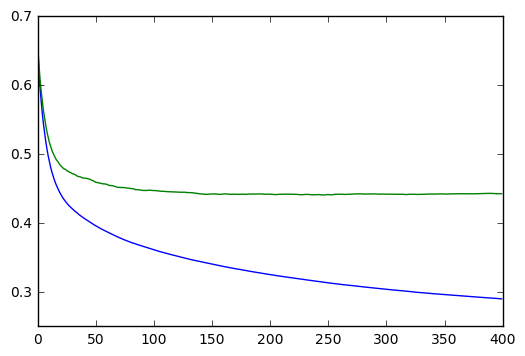

In [877]:
import matplotlib.pyplot as plt
i = 2
plt.plot([x[0] for x in custom_xgb.eva.iloc[i]])
plt.plot([x[1] for x in custom_xgb.eva.iloc[i]])
plt.show()

In [841]:
xgb_params = [ \
    ('learning_rate', [0.1]),
    ('min_child_weight', [0.1]),
    ('subsample', [1.0]),
    ('colsample_bytree', [1.0]),
    ('colsample_bylevel', [1.0]),
    ('gamma', [0]),
    ('max_depth', [1, 2, 3])
]

In [107]:
xgb_ = XGBClassifier()

xgb_params = {
    'learning_rate':[0.1],
    'n_estimators':[80, 90],
    'min_child_weight':[0.1],
    'subsample':[0.1],
    'colsample_bytree':[1.0],
    'colsample_bylevel':[1.0],
    'gamma':[0],
    'max_depth':[1, 3, 5]
}

grid = GridSearchCV(xgb_, xgb_params, scoring='mean_squared_error', cv=None, verbose=1, n_jobs=8)
grid.fit(X, Y)
print grid.best_params_
print grid.best_score_

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:   30.0s finished


{'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'learning_rate': 0.1, 'min_child_weight': 0.1, 'n_estimators': 80, 'subsample': 0.1, 'max_depth': 3, 'gamma': 0}
-150.929478138


In [108]:
best = grid.best_params_
d_train = xgb.DMatrix(X, label=Y)
a = xgb.cv(best, d_train, metrics=['rmse'], nfold=3, num_boost_round=100)
print a['test-rmse-mean'].min()
print a['test-rmse-mean'].argmin()

10.0796273333
49


In [109]:
best_n_rounds = a['test-rmse-mean'].argmin()
model = xgb.train(best, d_train, num_boost_round=best_n_rounds)

In [16]:
def spread_to_percent(spread):
    return 1/(1 + 10 ** (-spread / 15))

In [15]:
import scipy as sp
def logloss(act, pred):
    epsilon = 1e-15
    pred = sp.maximum(epsilon, pred)
    pred = sp.minimum(1-epsilon, pred)
    ll = sum(act*sp.log(pred) + sp.subtract(1,act)*sp.log(sp.subtract(1,pred)))
    ll = ll * -1.0/len(act)
    return ll

In [112]:
train_pred = xgb.DMatrix(X)
preds = spread_to_percent(model.predict(train_pred))
Y_ = [0 if y < 0 else 1 for y in Y]

In [113]:
logloss(Y_, preds)

0.43438507691721928

In [114]:
cv_pred = xgb.DMatrix(X_cv)
cv_preds = spread_to_percent(model.predict(cv_pred))
Y_cv_ = [0 if y < 0 else 1 for y in Y_cv]

In [115]:
logloss(Y_cv_, cv_preds)

0.477568577052979

In [116]:
#zip(cv_preds, Y_cv_)
sum([1 if round(x) == y else 0 for x,y in zip(cv_preds, Y_cv_)]) / float(len(cv_preds))

0.7412935323383084